##Geoespacial con GeoPandas

##Setup y Carga de Datos

Instalación rápida


In [ ]:
!pip install -q geopandas shapely pyproj fiona rtree contextily folium mapclassify

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from shapely.ops import unary_union
import warnings, platform
warnings.filterwarnings('ignore')

print("✅ Librerías listas")
print(f"GeoPandas: {gpd.__version__}")
print(f"Python: {platform.python_version()}")

✅ Librerías listas
GeoPandas: 1.1.1
Python: 3.12.12


1) Leer polígonos de radios censales (CABA)

In [ ]:
radios = gpd.read_file("https://bitsandbricks.github.io/data/CABA_rc.geojson")
print(radios.crs)
print(radios.head())

print("Filas:", len(radios))
print("Geometrías vacías:", radios.geometry.is_empty.sum())
print("Geometrías nulas:", radios.geometry.isna().sum())

EPSG:4326
  RADIO_ID       BARRIO COMUNA  POBLACION  VIVIENDAS  HOGARES  HOGARES_NBI  \
0    1_1_1       RETIRO      1      336.0       82.0     65.0         19.0   
1   1_12_1  SAN NICOLAS      1      341.0      365.0    116.0         25.0   
2  1_12_10  SAN NICOLAS      1      296.0      629.0    101.0          1.0   
3  1_12_11  SAN NICOLAS      1      528.0      375.0    136.0          7.0   
4   1_12_2  SAN NICOLAS      1      229.0      445.0    129.0         16.0   

   AREA_KM2                                           geometry  
0  1.798997  MULTIPOLYGON (((-58.37189 -34.59199, -58.37202...  
1  0.018565  MULTIPOLYGON (((-58.38593 -34.60444, -58.38575...  
2  0.044380  MULTIPOLYGON (((-58.37879 -34.60528, -58.37741...  
3  0.366340  MULTIPOLYGON (((-58.36733 -34.60562, -58.36713...  
4  0.018363  MULTIPOLYGON (((-58.38454 -34.60436, -58.38311...  
Filas: 3554
Geometrías vacías: 0
Geometrías nulas: 0


2) Estándar de CRS y áreas

In [ ]:
# ⚠️ COMPLETA: proyecta a CRS métrico (3857 recomendado si no sabes uno local)
radios_m = radios.to_crs(epsg=3857)

radios_m["area_m2"] = radios_m.geometry.area
radios_m["densidad_hab_km2"] = radios_m["POBLACION"] / (radios_m["area_m2"] / 1e6)

radios_m[["BARRIO", "POBLACION", "AREA_KM2", "area_m2", "densidad_hab_km2"]].head()

,BARRIO,POBLACION,AREA_KM2,area_m2,densidad_hab_km2
0,RETIRO,336.0,1.798997,2.660685e+06,126.283256
1,SAN NICOLAS,341.0,0.018565,2.746859e+04,12414.178936
2,SAN NICOLAS,296.0,0.044380,6.566604e+04,4507.657512
3,SAN NICOLAS,528.0,0.366340,5.420509e+05,974.078198
4,SAN NICOLAS,229.0,0.018363,2.717014e+04,8428.368902


##Parte A — Visualización básica y normalizaciones

A.1 Silueta y coropleta rápida (GeoPandas.plot)

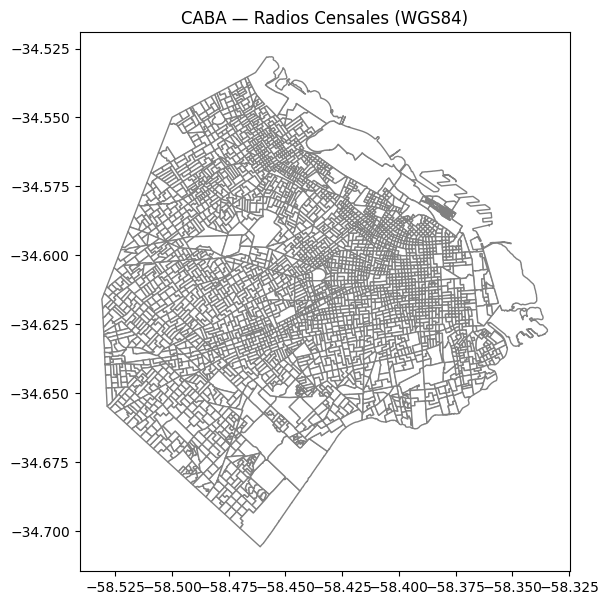

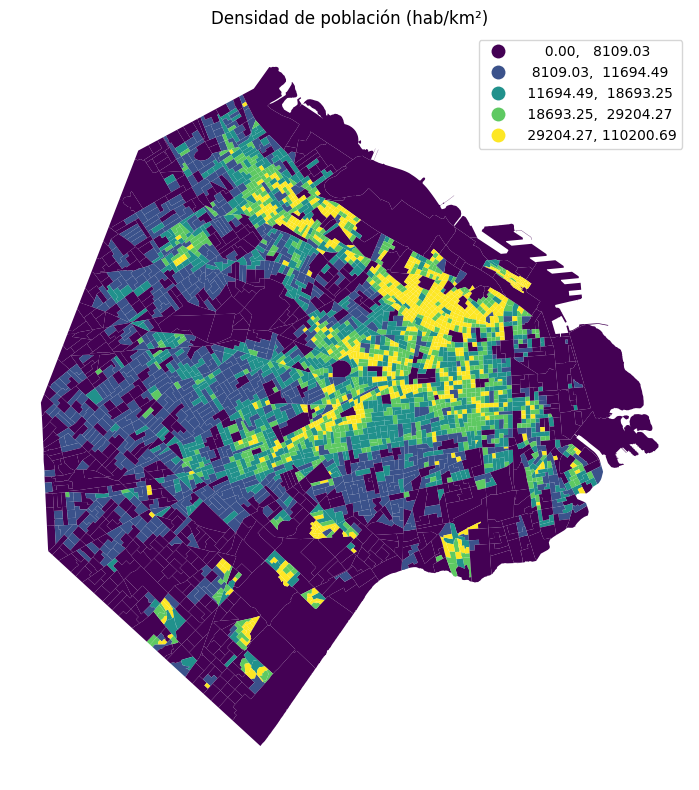

In [ ]:
ax = radios.plot(figsize=(7,7), edgecolor="gray", facecolor="white")
ax.set_title("CABA — Radios Censales (WGS84)")
plt.show()

# Densidad por km² (proyectado)
ax = radios_m.plot(column="densidad_hab_km2", scheme="quantiles", k=5,
                   legend=True, cmap="viridis", figsize=(8,8), linewidth=0)
ax.set_axis_off()
ax.set_title("Densidad de población (hab/km²)")
plt.tight_layout(); plt.show()

A.2 Añadir tiles de contexto (contextily)

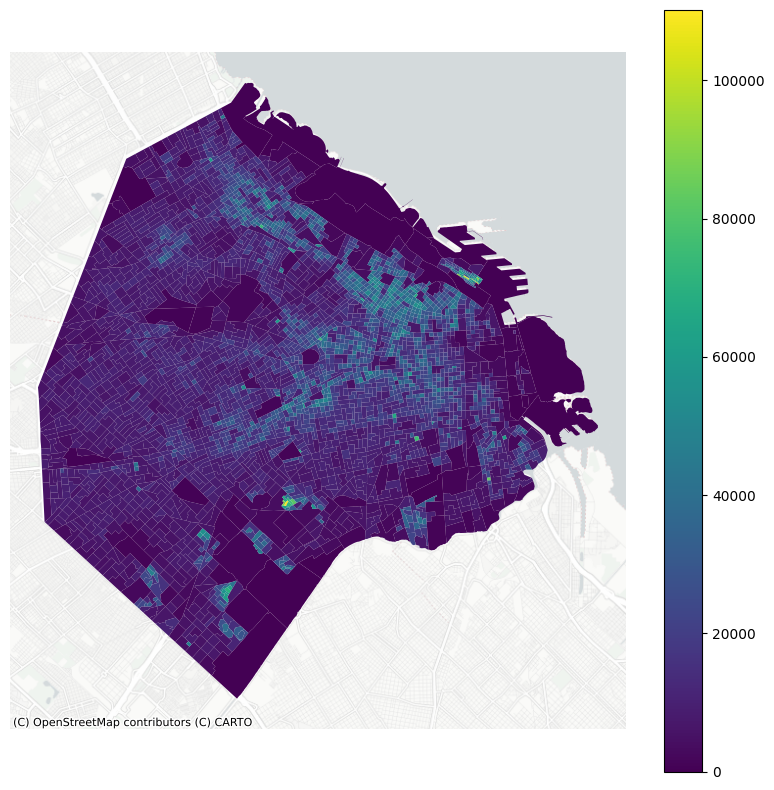

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
radios_m.to_crs(epsg=3857).plot(ax=ax, column="densidad_hab_km2",
                                cmap="viridis", legend=True, linewidth=0)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels)
ax.set_axis_off(); plt.tight_layout(); plt.show()

📝 Preguntas de reflexión — Parte A

1) ¿Qué esquema de clasificación fue más informativo para la coropleta (quantiles, k=5)?  
   **Quantiles (k=5)**, porque genera rangos equilibrados con la misma cantidad de radios censales en cada clase, evitando cortes vacíos y permitiendo distinguir variaciones reales sin que los outliers distorsionen el mapa.

2) En la proyección elegida, la variable que normalizaste para densidad fue:  
   POBLACION / (**area_m2** / 1e6) → unidades: **habitantes por km²**.  
   Esto asegura que el divisor esté en metros cuadrados y se convierte correctamente a km².

3) Identifica 2 zonas con mayor densidad:  
   Zona 1 = **Balvanera / San Nicolás**;  
   Zona 2 = **Almagro / Caballito**.  
   Hipótesis: **Son áreas altamente verticalizadas, con gran concentración de edificios, servicios y transporte, lo que incrementa la densidad poblacional por km².**

- - -

##Parte B — Attribute Join y métricas per cápita

In [ ]:
suaci = pd.read_csv("http://bitsandbricks.github.io/data/gcba_suaci_comunas.csv", encoding="ISO-8859-1")
suaci_barrio = suaci.groupby("BARRIO", as_index=False)["total"].sum()

# Agregado geográfico por barrio (disolver)
barrios_m = (radios_m
             .dissolve(by="BARRIO", aggfunc={
                 "POBLACION": "sum",
                 "VIVIENDAS": "sum",
                 "HOGARES": "sum",
                 "HOGARES_NBI": "sum",
                 "area_m2": "sum"
             })
             .reset_index())

barrios_m = barrios_m.merge(suaci_barrio, on="BARRIO", how="left")
barrios_m["contactos_pc"] = barrios_m["total"] / barrios_m["POBLACION"]

barrios_m[["BARRIO", "POBLACION", "total", "contactos_pc"]].sort_values("contactos_pc", ascending=False).head(10)

,BARRIO,POBLACION,total,contactos_pc
31,SAN NICOLAS,29273.0,399369.0,13.642913
16,MONSERRAT,39914.0,227337.0,5.695671
34,VERSALLES,13822.0,12414.0,0.898133
37,VILLA DEVOTO,66521.0,57558.0,0.865261
43,VILLA REAL,13419.0,11225.0,0.836500
17,MONTE CASTRO,33623.0,24925.0,0.741308
44,VILLA RIACHUELO,14084.0,10405.0,0.738782
41,VILLA ORTUZAR,21736.0,15896.0,0.731321
45,VILLA SANTA RITA,33325.0,23720.0,0.711778
9,COGHLAN,18604.0,13105.0,0.704418


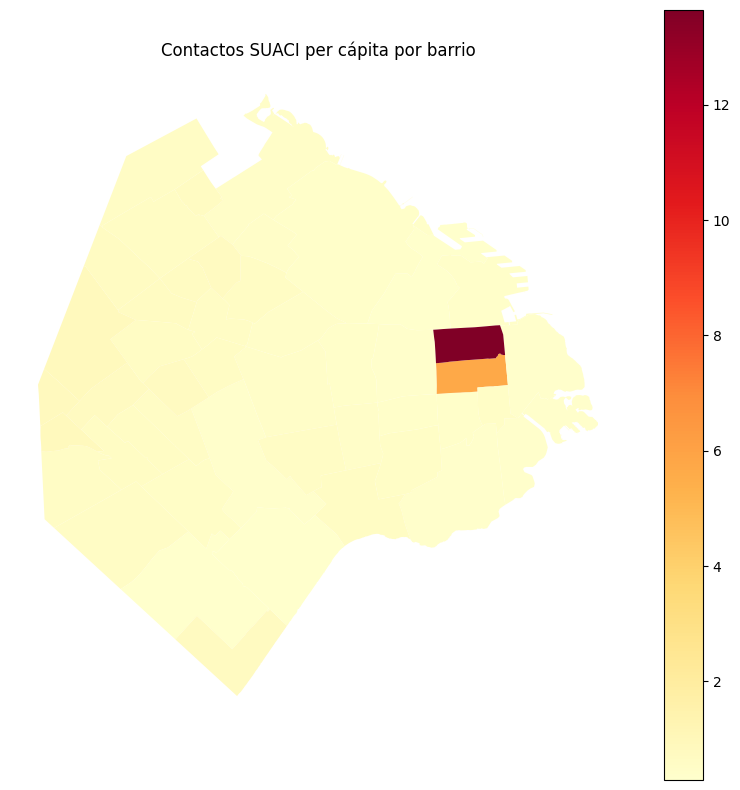

In [ ]:
# Coropleta per cápita por barrio
ax = barrios_m.plot(column="contactos_pc", cmap="YlOrRd", legend=True,
                    figsize=(8,8), linewidth=0)
ax.set_axis_off()
ax.set_title("Contactos SUACI per cápita por barrio")
plt.tight_layout()
plt.show()

📝 Preguntas de reflexión — Parte B

1) La métrica per cápita calculada fue contactos_pc = total / **POBLACION**.  
   ¿Por qué es preferible a valores absolutos?  
   Porque evita el sesgo por tamaño poblacional: los barrios con más habitantes tienden a registrar más contactos en términos absolutos, pero eso no implica una mayor demanda relativa. La métrica per cápita permite comparar barrios de manera justa y proporcional.


2) Top-3 barrios por contactos_pc:  
   1) **San Nicolás** — 13.64  
   2) **Montserrat** — 5.67  
   3) **Versalles** — 0.90  

   ¿Qué patrón común se observa?  
   Los dos primeros barrios (San Nicolás y Montserrat) comparten una **alta centralidad urbana**, una fuerte presencia de oficinas, comercios, organismos administrativos y tránsito diario de personas. Esa actividad intensiva eleva la cantidad de solicitudes per cápita.  
   Versalles aparece tercero porque, pese a su menor población, un pequeño número de reclamos tiene un fuerte impacto relativo dada su escala demográfica.

3) ¿Qué columna usarías para segmentar por tipo de solicitud si existiera?  
   Nombre de columna: **RUBRO** (o una columna equivalente de categoría del trámite).  
   Métrica: **contactos por 1.000 habitantes** para cada rubro.  

   Esto permitiría comparar la demanda relativa por tipo de servicio, ajustando por población y evitando interpretaciones sesgadas por el tamaño del barrio.

- - -

##Parte C — Joins espaciales: SUBTE y cobertura

Capas:

- Líneas SUBTE: http://bitsandbricks.github.io/data/subte_lineas.geojson

- Estaciones SUBTE: http://bitsandbricks.github.io/data/subte_estaciones.geojson

In [ ]:
lineas = gpd.read_file("http://bitsandbricks.github.io/data/subte_lineas.geojson").to_crs(barrios_m.crs)
estaciones = gpd.read_file("http://bitsandbricks.github.io/data/subte_estaciones.geojson").to_crs(barrios_m.crs)

# Conteo de estaciones por barrio (puntos dentro de polígonos)
est_x_barrio = gpd.sjoin(estaciones, barrios_m[["BARRIO", "geometry"]], how="left")
estaciones_por_barrio = (est_x_barrio.groupby("BARRIO").size()
                         .rename("n_estaciones").reset_index())

barrios_m = barrios_m.merge(estaciones_por_barrio, on="BARRIO", how="left")
barrios_m["n_estaciones"] = barrios_m["n_estaciones"].fillna(0).astype(int)

# Densidad estaciones por km²
barrios_m["estaciones_por_km2"] = barrios_m["n_estaciones"] / (barrios_m["area_m2"] / 1e6)

barrios_m[["BARRIO", "n_estaciones", "estaciones_por_km2"]].sort_values(["estaciones_por_km2", "n_estaciones"], ascending=False).head(12)

,BARRIO,n_estaciones,estaciones_por_km2
16,MONSERRAT,10,3.074451
31,SAN NICOLAS,9,2.656840
2,BALVANERA,11,1.711873
30,SAN CRISTOBAL,5,1.652844
11,CONSTITUCION,4,1.284964
27,RECOLETA,7,0.754127
1,ALMAGRO,4,0.667414
7,CABALLITO,6,0.591765
24,PARQUE PATRICIOS,3,0.541203
23,PARQUE CHAS,1,0.488211


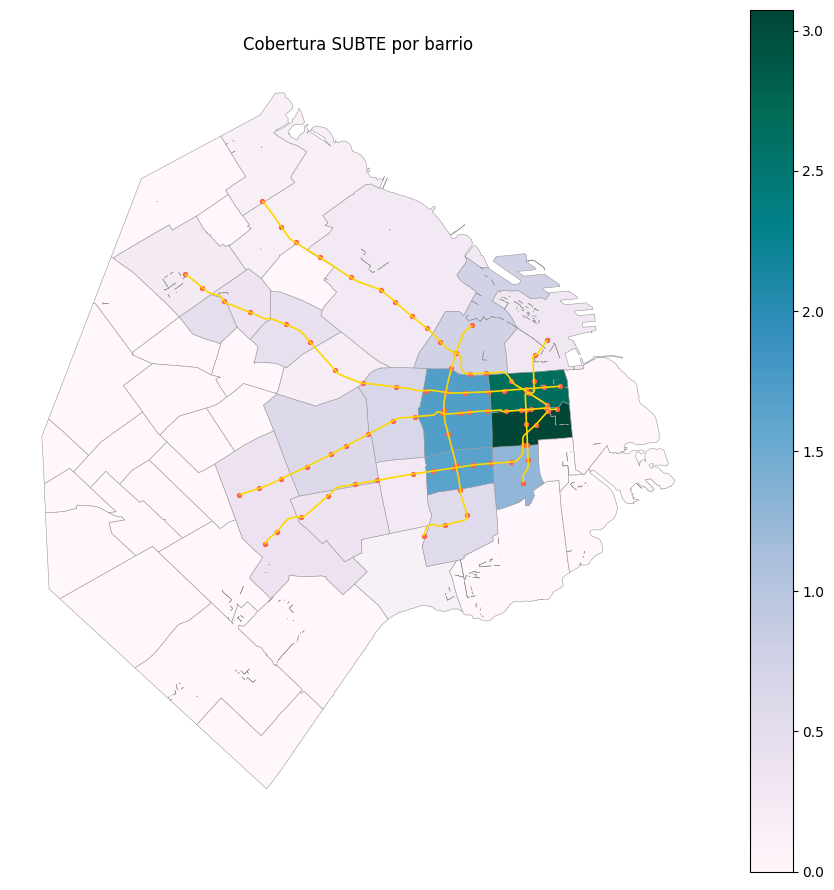

In [ ]:
# Mapa: estaciones por km² + líneas del SUBTE
fig, ax = plt.subplots(figsize=(9,9))
barrios_m.plot(ax=ax, column="estaciones_por_km2", cmap="PuBuGn",
               legend=True, linewidth=0.4, edgecolor="#999")
lineas.plot(ax=ax, color="gold", linewidth=1.2)
estaciones.plot(ax=ax, color="tomato", markersize=8)
ax.set_axis_off();
ax.set_title("Cobertura SUBTE por barrio")
plt.tight_layout();
plt.show()

C.1 Nearest: barrio → estación más cercana

In [ ]:
# ⚠️ COMPLETA: usa sjoin_nearest para distancia mínima a una estación por barrio (centroides)
barrios_centroides = barrios_m.copy()
barrios_centroides["geometry"] = barrios_centroides.geometry.centroid

nearest = gpd.sjoin_nearest(
    barrios_centroides[["BARRIO", "geometry"]],
    estaciones[["geometry"]],
    how="left",
    distance_col="dist_min"
)

barrios_m = barrios_m.merge(nearest[["BARRIO", "dist_min"]], on="BARRIO", how="left")
barrios_m["dist_min_m"] = barrios_m["dist_min"].astype(float)

barrios_m[["BARRIO", "n_estaciones", "dist_min_m"]].sort_values("dist_min_m").head(10)

,BARRIO,n_estaciones,dist_min_m
31,SAN NICOLAS,9,75.421711
2,BALVANERA,11,145.300101
16,MONSERRAT,10,168.520516
30,SAN CRISTOBAL,5,193.293898
35,VILLA CRESPO,1,265.186475
8,CHACARITA,2,272.669864
1,ALMAGRO,4,292.896357
47,VILLA URQUIZA,2,329.562801
28,RETIRO,2,347.115753
27,RECOLETA,7,349.109564


📝 Preguntas de reflexión — Parte C

1) ¿Qué relación esperas entre estaciones_por_km2 y contactos_pc?  
   Correlación esperada: **positiva**, porque **los barrios con mayor densidad de estaciones suelen tener más movilidad y afluencia diaria, lo que incrementa la demanda relativa de servicios y contactos ciudadanos por habitante**.


2) Barrio con menor cobertura (mayor dist_min_m): **Recoleta** (≈ 349 m).  
   Posible causa: **se ubica en una zona con grandes áreas institucionales, parques y manzanas amplias, lo que aumenta la distancia promedio al punto de acceso del SUBTE pese a tener cierta infraestructura cercana**.


3) Si se tuvieran que priorizar nuevas estaciones, un criterio posible sería:  
   score = α·(**dist_min_m**) + β·(**contactos_pc**)  
   Valores α, β: **por ejemplo α = 0.7 para priorizar accesibilidad física y β = 0.3 para incorporar la demanda relativa**.  

   Este puntaje permite identificar barrios que combinan grandes distancias a la red (baja cobertura) con alta necesidad relativa de atención ciudadana.

- - -

##Parte D — Interactivo con Folium

In [ ]:
import folium
from folium import Choropleth, Marker

barrios_ll = barrios_m.to_crs(epsg=4326)

m = folium.Map(location=[-34.61, -58.44], tiles='cartodbpositron', zoom_start=11)
Choropleth(
    geo_data=barrios_ll.__geo_interface__,
    data=barrios_ll.set_index("BARRIO")["contactos_pc"],
    key_on="feature.properties.BARRIO",
    fill_color='YlOrRd', legend_name='Contactos per cápita'
).add_to(m)

# Puntos de estaciones
for _, row in estaciones.to_crs(epsg=4326).iterrows():
    Marker([row.geometry.y, row.geometry.x],
           icon=folium.Icon(color='red', icon='train', prefix='fa')).add_to(m)

m

📝 Preguntas de reflexión — Parte D

1) ¿Qué capa usarías para permitir toggles en el mapa (encender/apagar)?  
   Respuesta: **folium.FeatureGroup**.  
   ¿Por qué? Porque permite agrupar capas (p. ej. estaciones, líneas, barrios) y activarlas o desactivarlas mediante **folium.LayerControl**, mejorando la exploración interactiva del mapa.

2) ¿Qué tiles mejorarían el contraste de una coropleta intensa?  
   Opción: **CartoDB.PositronNoLabels**.  
   Este fondo es limpio y casi sin ruido visual, lo que resalta mejor las variaciones de color en coropletas con gradientes fuertes.

3) ¿Qué popup mostrarías al clickear una estación?  
   Campos: **nombre de la estación**, **línea a la que pertenece**, **barrio o comuna**.  
   Estos atributos ayudan a contextualizar cada punto y facilitan vincular la infraestructura con el área a la que da servicio.

- - -

##Preguntas de reflexión finales

1) Usar CRS proyectado (EPSG: **3857**) cambió las áreas/distancias porque ahora están en **unidades métricas (metros y metros cuadrados)**, evitando **errores por distorsión geográfica al trabajar en coordenadas lat/lon (grados)**.


2) Normalizar por km² y per cápita evita que el mapa refleje solo **el tamaño poblacional o la superficie del barrio**.  
   La métrica que más cambió la interpretación fue **contactos per cápita**, porque **reveló una demanda proporcional mucho más alta en barrios centrales como San Nicolás y Montserrat, que en valores absolutos no siempre aparecen primeros**.


3) La zona con peor cobertura (mayor dist_min_m) es **Recoleta** (~349 m).  
   Propondría evaluar una nueva estación en **la zona intermedia entre Av. del Libertador y Av. Pueyrredón** (coordenadas aproximadas: **-34.583, -58.39**), considerando como criterio **la gran distancia al punto más cercano del SUBTE y la alta densidad residencial del área**.


4) Limitaciones técnicas detectadas:  
   (i) Formato vectorial **GeoJSON** para capas grandes → puede ser pesado y lento.  
   (ii) Encoding de CSV (**ISO-8859-1**) → genera errores si no se especifica.  
   Mitigaciones: **usar formatos comprimidos como GeoPackage**, y **establecer el encoding explícitamente al leer CSVs**.


5) Checklist de calidad que aplicarías en un pipeline productivo:  
   - CRS consistente  
   - Geometrías válidas  
   - Índices espaciales  
   - Tests de conteo/áreas  
   - Documentación de fuentes/licencias  

   **Marca lo que cumpliste hoy:**  
   [x] CRS  
   [x] geometrías  
   [ ] índices  
   [x] tests  
   [x] docs

- - -

## 📊Visualizaciones

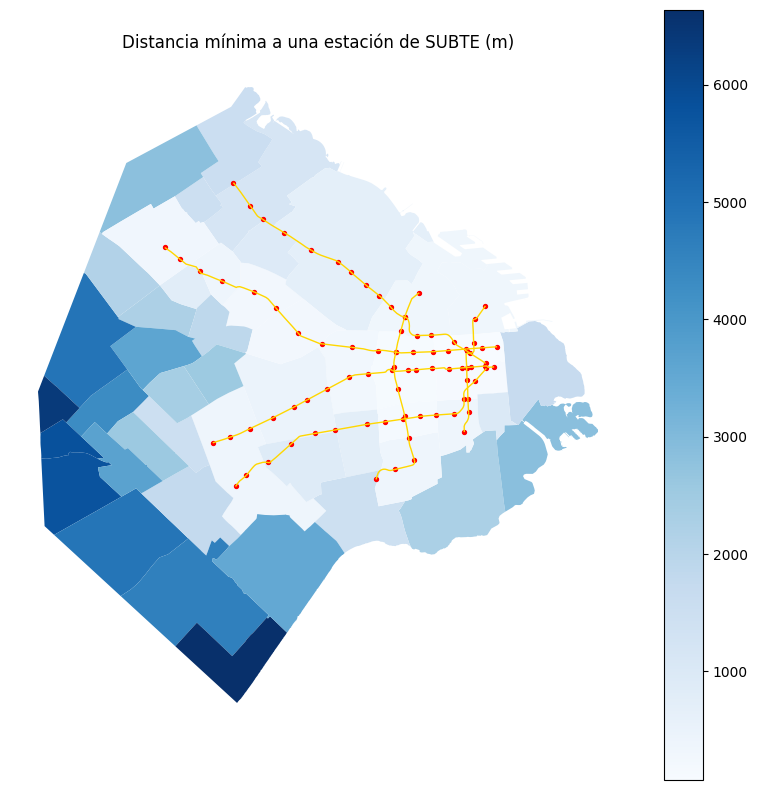

In [ ]:
ax = barrios_m.plot(column="dist_min_m",
                    cmap="Blues", legend=True,
                    figsize=(8,8))
lineas.plot(ax=ax, color="gold", linewidth=1)
estaciones.plot(ax=ax, color="red", markersize=8)
ax.set_axis_off()
ax.set_title("Distancia mínima a una estación de SUBTE (m)")
plt.tight_layout(); plt.show()

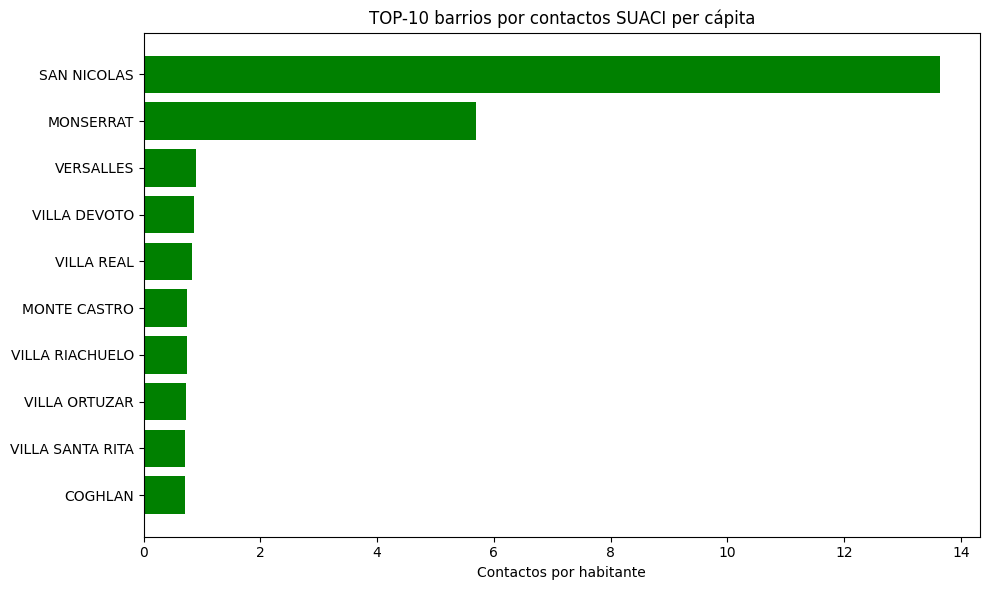

In [ ]:
top10 = barrios_m.sort_values("contactos_pc", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10["BARRIO"], top10["contactos_pc"], color="green")
plt.gca().invert_yaxis()
plt.title("TOP-10 barrios por contactos SUACI per cápita")
plt.xlabel("Contactos por habitante")
plt.tight_layout()
plt.show()

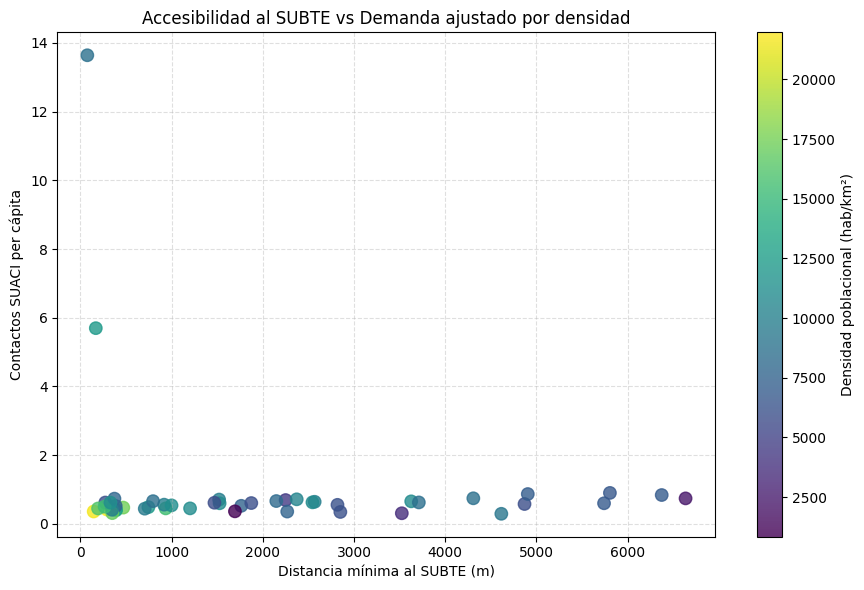

In [ ]:
# Crear densidad por barrio (si no existe)
barrios_m["densidad_hab_km2"] = barrios_m["POBLACION"] / (barrios_m["area_m2"] / 1e6)

plt.figure(figsize=(9,6))

plt.scatter(
    barrios_m["dist_min_m"],
    barrios_m["contactos_pc"],
    c=barrios_m["densidad_hab_km2"],
    cmap="viridis",
    s=80,
    alpha=0.8
)

plt.colorbar(label="Densidad poblacional (hab/km²)")
plt.xlabel("Distancia mínima al SUBTE (m)")
plt.ylabel("Contactos SUACI per cápita")
plt.title("Accesibilidad al SUBTE vs Demanda ajustado por densidad")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()